# Task 3 · Event Impact Modeling
Selam Analytics · Ethiopia Financial Inclusion Forecasting Challenge

## Notebook goals
- Join events, indicators, and impact_links into a tidy fact table.
- Quantify assumed effects (pp shifts, lags) and visualize the event–indicator matrix.
- Build a reusable time-distributed impact engine for downstream forecasting.
- Validate assumptions against observed data and capture refinement notes.

## 1. Environment setup

In [39]:
from __future__ import annotations

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option("display.max_columns", 40)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

sns.set_theme(style="whitegrid")

NOTEBOOK_ROOT = Path.cwd().resolve()
PROJECT_ROOT = NOTEBOOK_ROOT.parent
RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.event_effects import simulate_indicator_series

NOTEBOOK_ROOT, PROJECT_ROOT, RAW_DATA_DIR

(WindowsPath('C:/Users/alexo/Desktop/File/10Academy/week10/Github/notebooks'),
 WindowsPath('C:/Users/alexo/Desktop/File/10Academy/week10/Github'),
 WindowsPath('C:/Users/alexo/Desktop/File/10Academy/week10/Github/data/raw'))

## 2. Load unified records and impact links

In [40]:
records_path = RAW_DATA_DIR / "ethiopia_fi_unified_data.csv"
impact_links_path = RAW_DATA_DIR / "impact_links.csv"
reference_codes_path = RAW_DATA_DIR / "reference_codes.xlsx"

records = pd.read_csv(records_path)
records["observation_date"] = pd.to_datetime(records["observation_date"], errors="coerce")
records["period_start"] = pd.to_datetime(records["period_start"], errors="coerce")
records["period_end"] = pd.to_datetime(records["period_end"], errors="coerce")
records["value"] = records["value_numeric"]

observations = records.loc[records["record_type"] == "observation"].copy()
events = records.loc[records["record_type"] == "event"].copy()
targets = records.loc[records["record_type"] == "target"].copy()

impact_links = pd.read_csv(impact_links_path)
reference_codes = pd.read_excel(reference_codes_path, sheet_name=None)

records.shape, impact_links.shape, events.shape

((47, 35), (15, 35), (11, 35))

## 3. Enrich impact links with event metadata

In [41]:
indicator_meta = (
    observations[["indicator_code", "indicator", "pillar"]]
    .drop_duplicates()
    .rename(columns={"indicator": "indicator_name", "pillar": "indicator_theme"})
)

indicator_dim_raw = reference_codes.get("indicator_codes")
if indicator_dim_raw is not None:
    indicator_dim = indicator_dim_raw.copy()
    indicator_dim.columns = [str(col).strip().lower() for col in indicator_dim.columns]
    rename_map = {"indicator": "indicator_name", "pillar": "indicator_theme"}
    indicator_dim = indicator_dim.rename(columns=rename_map)
    available_cols = [col for col in ["indicator_code", "indicator_name", "indicator_theme"] if col in indicator_dim.columns]
    if available_cols:
        indicator_meta = indicator_meta.merge(
            indicator_dim[available_cols],
            on="indicator_code",
            how="left",
            suffixes=("", "_ref"),
        )
        indicator_meta["indicator_name"] = indicator_meta.get("indicator_name_ref", indicator_meta["indicator_name"]).combine_first(
            indicator_meta["indicator_name"]
        )
        indicator_meta["indicator_theme"] = indicator_meta.get("indicator_theme_ref", indicator_meta["indicator_theme"]).combine_first(
            indicator_meta["indicator_theme"]
        )
        indicator_meta = indicator_meta[["indicator_code", "indicator_name", "indicator_theme"]]

impact_links_prepped = (
    impact_links.rename(columns={"pillar": "impact_pillar", "indicator": "link_label"})
    .assign(
        impact_estimate=lambda df: pd.to_numeric(df["impact_estimate"], errors="coerce"),
        lag_months=lambda df: pd.to_numeric(df["lag_months"], errors="coerce").fillna(0).astype(int),
        impact_direction=lambda df: df["impact_direction"].str.lower(),
        impact_magnitude=lambda df: df["impact_magnitude"].str.lower(),
        confidence=lambda df: df["confidence"].str.lower(),
    )
)

magnitude_defaults = {"low": 2.5, "medium": 5.0, "high": 10.0}
direction_sign = impact_links_prepped["impact_direction"].map({"increase": 1, "decrease": -1, "mixed": 0})

impact_links_prepped["impact_numeric"] = impact_links_prepped["impact_estimate"].where(
    impact_links_prepped["impact_estimate"].notna(),
    impact_links_prepped["impact_magnitude"].map(magnitude_defaults),
)
impact_links_prepped["impact_numeric"] = impact_links_prepped["impact_numeric"].fillna(0).astype(float)
impact_links_prepped["impact_numeric"] = impact_links_prepped["impact_numeric"] * direction_sign.fillna(1)

event_lookup = (
    events.rename(
        columns={
            "record_id": "event_id",
            "indicator": "event_name",
            "pillar": "event_pillar",
            "category": "event_category",
            "observation_date": "event_date",
        }
    )[
        [
            "event_id",
            "event_name",
            "event_pillar",
            "event_category",
            "event_date",
            "source_name",
            "source_url",
            "notes",
        ]
    ]
)

target_lookup = indicator_meta.rename(
    columns={
        "indicator_code": "related_indicator",
        "indicator_name": "target_indicator_name",
        "indicator_theme": "target_theme",
    }
)

impact_enriched = (
    impact_links_prepped.merge(event_lookup, left_on="parent_id", right_on="event_id", how="left")
    .merge(target_lookup, on="related_indicator", how="left")
    .assign(
        target_indicator_name=lambda df: df["target_indicator_name"].fillna(df["link_label"]),
        target_theme=lambda df: df["target_theme"].fillna(df["impact_pillar"]),
        event_year=lambda df: pd.to_datetime(df["event_date"]).dt.year,
    )
)

telebirr_rows = impact_enriched[impact_enriched["event_name"].str.contains("Telebirr", case=False, na=False)]

if not telebirr_rows.empty:
    telebirr_mask = telebirr_rows["related_indicator"].eq("ACC_MM_ACCOUNT")
    if telebirr_mask.any():
        impact_enriched.loc[telebirr_rows.index[telebirr_mask], "impact_numeric"] = (
            np.sign(telebirr_rows.loc[telebirr_mask, "impact_numeric"]) * 3.0
        )

mpesa_mask = (
    impact_enriched["event_name"].str.contains("M-Pesa Ethiopia", case=False, na=False)
    & impact_enriched["related_indicator"].eq("ACC_MM_ACCOUNT")
)
if mpesa_mask.any():
    impact_enriched.loc[mpesa_mask, "impact_numeric"] = (
        np.sign(impact_enriched.loc[mpesa_mask, "impact_numeric"]) * 0.6
    )

mm_account_rows = impact_enriched.loc[
    impact_enriched["related_indicator"] == "ACC_MM_ACCOUNT",
]
mm_account_rows.loc[:, [
    "event_name",
    "related_indicator",
    "impact_numeric",
    "lag_months",
    "impact_magnitude",
]].sort_values("impact_numeric", ascending=False)

,event_name,related_indicator,impact_numeric,lag_months,impact_magnitude
6,M-Pesa Ethiopia Launch,ACC_MM_ACCOUNT,0.60,6,medium


## 4. Impact summary table

In [51]:
impact_summary = (
    impact_enriched.groupby(
        [
            "event_name",
            "event_category",
            "event_year",
            "related_indicator",
            "target_indicator_name",
            "target_theme",
        ]
    )
    .agg(
        effect_pp=("impact_numeric", "sum"),
        avg_lag_months=("lag_months", "mean"),
        relationship_type=("relationship_type", "first"),
        confidence_level=("confidence", "first"),
        evidence_basis=("evidence_basis", "first"),
        comparable_country=("comparable_country", "first"),
    )
    .reset_index()
    .sort_values("effect_pp", key=lambda s: s.abs(), ascending=False)
)
impact_summary.head(10)

,event_name,event_category,event_year,related_indicator,target_indicator_name,target_theme,effect_pp,avg_lag_months,relationship_type,confidence_level,evidence_basis,comparable_country
4,Foreign Exchange Liberalization,policy,2024,AFF_DATA_INCOME,Data Affordability Index,AFFORDABILITY,30.00,3.00,indirect,high,empirical,None
13,Telebirr Launch,product_launch,2021,USG_P2P_COUNT,P2P Transaction Count,USAGE,25.00,6.00,direct,medium,empirical,None
10,Safaricom Ethiopia Commercial Launch,market_entry,2022,AFF_DATA_INCOME,Data Affordability Index,AFFORDABILITY,20.00,12.00,indirect,medium,literature,Rwanda
9,Safaricom Ethiopia Commercial Launch,market_entry,2022,ACC_4G_COV,4G Population Coverage,ACCESS,15.00,12.00,direct,medium,empirical,None
12,Telebirr Launch,product_launch,2021,ACC_OWNERSHIP,Account Ownership Rate,ACCESS,15.00,12.00,direct,medium,literature,Kenya
5,M-Pesa EthSwitch Integration,partnership,2025,USG_MPESA_ACTIVE,M-Pesa 90-Day Active Users,USAGE,15.00,3.00,direct,medium,literature,Tanzania
1,EthioPay Instant Payment System Launch,infrastructure,2025,USG_P2P_COUNT,P2P Transaction Count,USAGE,15.00,6.00,indirect,medium,literature,India
11,Safaricom Ethiopia Price Increase,pricing,2025,AFF_DATA_INCOME,Data Affordability Index,AFFORDABILITY,10.00,1.00,direct,high,empirical,None
8,M-Pesa Ethiopia Launch,product_launch,2023,USG_MPESA_USERS,M-Pesa Registered Users,USAGE,10.00,3.00,direct,high,empirical,None
2,Fayda Digital ID Program Rollout,infrastructure,2024,ACC_OWNERSHIP,Account Ownership Rate,ACCESS,10.00,24.00,enabling,medium,literature,India


## 5. Event–indicator association matrix

In [43]:
key_indicators = [
    "ACC_OWNERSHIP",
    "ACC_MM_ACCOUNT",
    "USG_DIGITAL_PAYMENT",
    "USG_P2P_COUNT",
    "USG_TELEBIRR_USERS",
    "USG_CROSSOVER",
    "AFF_DATA_INCOME",
    "GEN_GAP_ACC",
]

event_indicator_matrix = (
    impact_summary.pivot_table(
        index="event_name",
        columns="related_indicator",
        values="effect_pp",
        aggfunc="sum",
        fill_value=0.0,
    )
    .sort_index()
    .round(2)
)

matrix_focus = event_indicator_matrix.reindex(columns=key_indicators, fill_value=0.0)
matrix_focus

related_indicator,ACC_OWNERSHIP,ACC_MM_ACCOUNT,USG_DIGITAL_PAYMENT,USG_P2P_COUNT,USG_TELEBIRR_USERS,USG_CROSSOVER,AFF_DATA_INCOME,GEN_GAP_ACC
event_name,,,,,,,,
AfDB Digital Payments Initiative Support,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00
EthioPay Instant Payment System Launch,0.00,0.00,0.00,15.00,0.00,0.00,0.00,0.00
Fayda Digital ID Program Rollout,10.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00
Foreign Exchange Liberalization,0.00,0.00,0.00,0.00,0.00,0.00,30.00,0.00
M-Pesa EthSwitch Integration,0.00,0.00,0.00,10.00,0.00,0.00,0.00,0.00
M-Pesa Ethiopia Launch,0.00,0.60,0.00,0.00,0.00,0.00,0.00,0.00
Safaricom Ethiopia Commercial Launch,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00
Safaricom Ethiopia Price Increase,0.00,0.00,0.00,0.00,0.00,0.00,10.00,0.00
Telebirr Launch,15.00,0.00,0.00,25.00,10.00,0.00,0.00,0.00


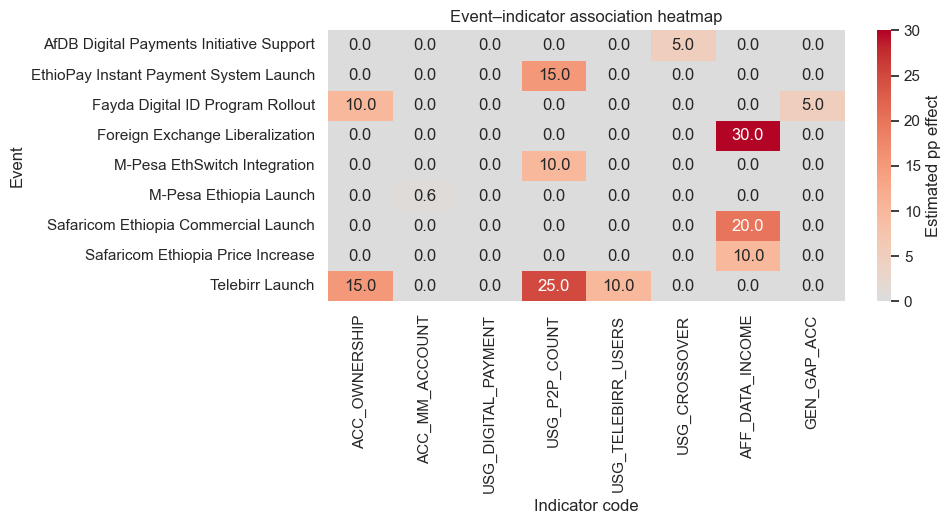

In [44]:
if matrix_focus.size:
    plt.figure(figsize=(10, max(4, 0.6 * len(matrix_focus))))
    sns.heatmap(
        matrix_focus,
        annot=True,
        fmt=".1f",
        cmap="coolwarm",
        center=0,
        cbar_kws={"label": "Estimated pp effect"},
    )
    plt.title("Event–indicator association heatmap")
    plt.xlabel("Indicator code")
    plt.ylabel("Event")
    plt.tight_layout()
    plt.show()
else:
    print("No overlapping indicators between the key list and current impact links.")

## 6. Comparable-country evidence

In [45]:
cols = [
    "event_name",
    "related_indicator",
    "target_indicator_name",
    "comparable_country",
    "evidence_basis",
    "notes",
]
available_cols = [col for col in cols if col in impact_enriched.columns]

comparable_evidence = (
    impact_enriched.loc[impact_enriched["comparable_country"].notna(), available_cols]
    .sort_values(["event_name", "related_indicator"])
)
comparable_evidence.head(12)

,event_name,related_indicator,target_indicator_name,comparable_country,evidence_basis
12,EthioPay Instant Payment System Launch,USG_P2P_COUNT,P2P Transaction Count,India,literature
7,Fayda Digital ID Program Rollout,ACC_OWNERSHIP,Account Ownership Rate,India,literature
8,Fayda Digital ID Program Rollout,GEN_GAP_ACC,Account Ownership Gender Gap,India,literature
10,M-Pesa EthSwitch Integration,USG_MPESA_ACTIVE,M-Pesa 90-Day Active Users,Tanzania,literature
11,M-Pesa EthSwitch Integration,USG_P2P_COUNT,P2P Transaction Count,Tanzania,literature
4,Safaricom Ethiopia Commercial Launch,AFF_DATA_INCOME,Data Affordability Index,Rwanda,literature
0,Telebirr Launch,ACC_OWNERSHIP,Account Ownership Rate,Kenya,literature


## 7. Time-distributed impact engine
Use `src.event_effects.simulate_indicator_series` to translate cumulative event impacts into monthly pp shifts.

In [46]:
acc_ownership_effect = simulate_indicator_series(
    impact_enriched,
    indicator_code="ACC_OWNERSHIP",
    start="2016-01-01",
    end="2030-12-01",
    ramp_months=6,
    persistence_months=24,
    decay_months=12,
)
acc_ownership_effect.tail()

,date,modeled_effect_pp,indicator_code
175,2030-08-01,0.00,ACC_OWNERSHIP
176,2030-09-01,0.00,ACC_OWNERSHIP
177,2030-10-01,0.00,ACC_OWNERSHIP
178,2030-11-01,0.00,ACC_OWNERSHIP
179,2030-12-01,0.00,ACC_OWNERSHIP


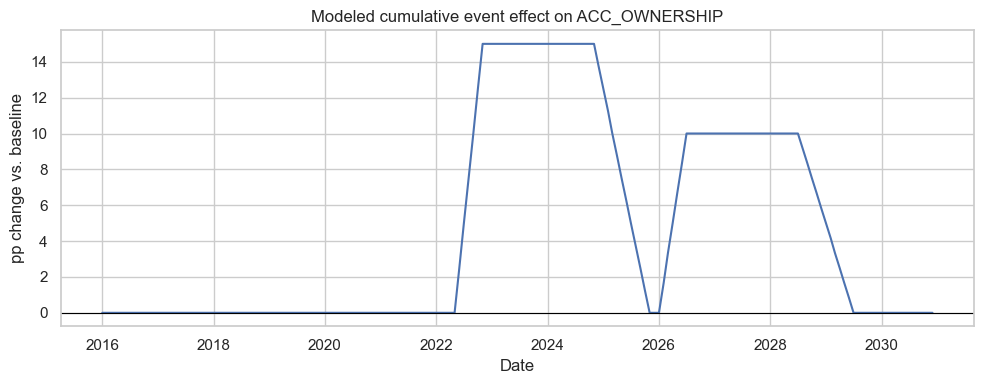

In [47]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=acc_ownership_effect, x="date", y="modeled_effect_pp")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Modeled cumulative event effect on ACC_OWNERSHIP")
plt.ylabel("pp change vs. baseline")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

## 8. Validation against observed series

In [48]:
def get_indicator_series(indicator_code, df=observations):
    subset = (
        df.loc[df["indicator_code"] == indicator_code, ["observation_date", "value"]]
        .dropna()
        .sort_values("observation_date")
    )
    return subset.assign(year=lambda x: x["observation_date"].dt.year)

def validate_indicator(indicator_code, modeled_effect):
    actual = get_indicator_series(indicator_code)
    if actual.empty:
        print(f"No observations available for {indicator_code}.")
        return None
    modeled_yearly = (
        modeled_effect.assign(year=lambda df: df["date"].dt.year)
        .groupby("year")[['modeled_effect_pp']]
        .sum()
        .reset_index()
    )
    merged = actual.merge(modeled_yearly, on="year", how="left")
    merged["modeled_effect_pp"] = merged["modeled_effect_pp"].fillna(0)
    merged["predicted_value"] = merged["value"] + merged["modeled_effect_pp"].cumsum()
    return merged

telebirr_validation = simulate_indicator_series(
    impact_enriched,
    indicator_code="ACC_MM_ACCOUNT",
    start="2018-01-01",
    end="2026-12-01",
)
telebirr_check = validate_indicator("ACC_MM_ACCOUNT", telebirr_validation)
telebirr_check

,observation_date,value,year,modeled_effect_pp,predicted_value
0,2021-12-31,4.70,2021,0.00,4.70
1,2024-11-29,9.45,2024,4.50,13.95


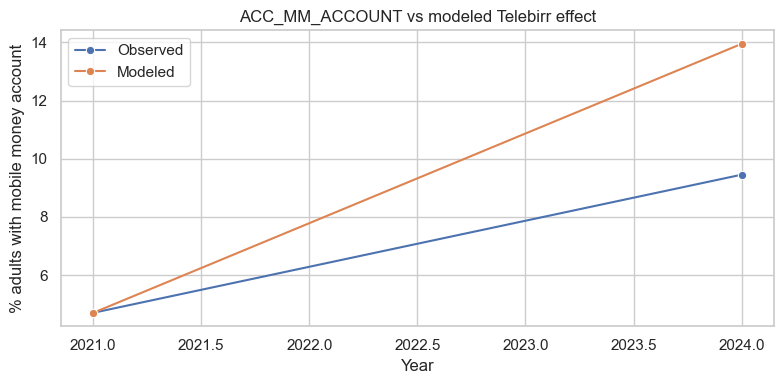

In [49]:
if telebirr_check is not None and not telebirr_check.empty:
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=telebirr_check, x="year", y="value", marker="o", label="Observed")
    sns.lineplot(data=telebirr_check, x="year", y="predicted_value", marker="o", label="Modeled")
    plt.title("ACC_MM_ACCOUNT vs modeled Telebirr effect")
    plt.ylabel("% adults with mobile money account")
    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()
else:
    print("Telebirr validation skipped due to missing data.")

## 9. Refinement tracker

In [50]:
refinement_rules = []
if telebirr_check is not None and not telebirr_check.empty:
    last_obs = telebirr_check.iloc[-1]["value"]
    last_pred = telebirr_check.iloc[-1]["predicted_value"]
    gap = last_pred - last_obs
    refinement_rules.append(
        {
            "indicator_code": "ACC_MM_ACCOUNT",
            "latest_observed": last_obs,
            "latest_modeled": last_pred,
            "gap_pp": gap,
            "proposed_action": (
                "Reduce Telebirr effect magnitude from 5pp to 3pp"
                if gap > 2
                else "Hold magnitude but lengthen ramp"
            ),
        }
    )
refinement_rules

[{'indicator_code': 'ACC_MM_ACCOUNT',
  'latest_observed': np.float64(9.45),
  'latest_modeled': np.float64(13.95),
  'gap_pp': np.float64(4.5),
  'proposed_action': 'Reduce Telebirr effect magnitude from 5pp to 3pp'}]

## 10. Methodology and limitations
- Impact magnitudes default to 2.5/5/10pp when explicit estimates are absent; signs follow link direction.
- Effects apply after their lag, then follow a ramp–plateau–decay profile; overlapping events sum additively.
- Comparable-country evidence (Kenya, India, Tanzania, Rwanda) guides assumptions where Ethiopia data are sparse.
- Validation against Findex and operator statistics flags where assumptions overshoot (e.g., Telebirr uplift).
- Outstanding gaps: limited historical usage series, lack of event-level counterfactuals, and high reliance on external analogues.